In [1]:
# import ROOT as R
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from pandas import HDFStore
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default="plotly_white"
pio.renderers.default = 'jupyterlab'  # Alternate: 'browser' opens new browser window with plots.

# Fetch the Data
The data was retrieved from MYA by the code RGD_Get_Current_Data.py, and stored in an HDF5 file. Here we simply load that data back in.

In [2]:
# Get the data from the HDF5 file.
store = HDFStore("RGD_raw_mya_data_copy.h5", mode='r')
current_IPM2C21A = store['IPM2C21A']
current_IPM2C24A = store['IPM2C24A']
current_IPM2H01 = store['IPM2H01']
current_scalerS2b = store['scalerS2b']
current_FCup = store['scaler_calc1b']
FCup_offset = store['fcup_offset']
FCup_slope = store['fcup_slope']
FCup_beam_stop = store['beam_stop']
FCup_beam_atten = store['beam_stop_atten']
LT_DAQ = store['DAQ_livetime']
LT_Trigger = store['Trigger_livetime']
LT_clock = store['Pulser_livetime']
store.close()

In [3]:
plot_start = datetime(2023,11,11,2,30,0)
plot_end =   plot_start + timedelta(hours=0, minutes=30) #datetime(2023,11,10,21,31)
print(f"Plotting from {plot_start} to {plot_end}, number of data points: {current_IPM2C21A.loc[(current_IPM2C21A.time>plot_start)&(current_IPM2C21A.time<plot_end)].time.count()}")
plot_set = [
            (current_IPM2C21A,"IPM2C21A","red"), 
            (current_IPM2C24A,"IPM2C24A","orange"),
            (current_IPM2H01,"IPM2H01","green"),
            (current_FCup,"FCup","blue"),
            (current_scalerS2b,"FCup_scalerS2b","aqua")]

Plotting from 2023-11-11 02:30:00 to 2023-11-11 03:00:00, number of data points: 1597


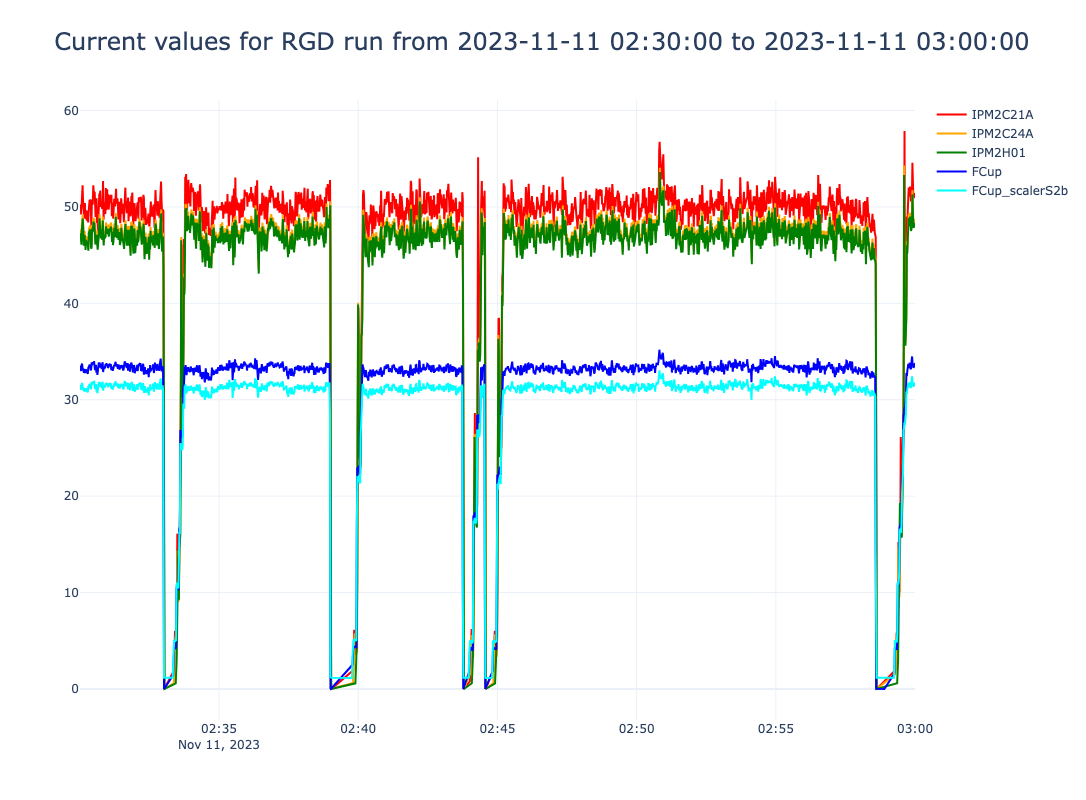

In [4]:
fig = make_subplots()  # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1000, height=800,
                  title=go.layout.Title(text=f"Current values for RGD run from {plot_start} to {plot_end}", xanchor="left"),
                  titlefont=dict(size=24),)
for current, name, color in plot_set:
    select = (current.time>plot_start)&(current.time<plot_end)
    if name == "FCup_scalerS2b":
        fig.add_trace(go.Scatter(x=current.loc[select].time, y=current.loc[select]["value"]/1000,  name=name, line=dict(color=color)))
    else:
        fig.add_trace(go.Scatter(x=current.loc[select].time, y=current.loc[select].value,  name=name, line=dict(color=color)))
fig.show()

In [5]:
current, name, color = (current_IPM2C21A,"IPM2C21A","red")
select = (current.time>plot_start)&(current.time<plot_end)
select_zero_start = (current.time>plot_start)&(current.time<plot_end) & (np.diff(current.value,prepend=0)<-0.2)& (current.value<.01)
select_zero_end   = (current.time>plot_start)&(current.time<plot_end) & ((np.diff(current.value,prepend=0)<-0.2)& (current.value<.01)).shift(periods=1)


Plotting zeros index start: 1977657 number of data points: 5
Plotting zeros index end:   1977658 number of data points: 5


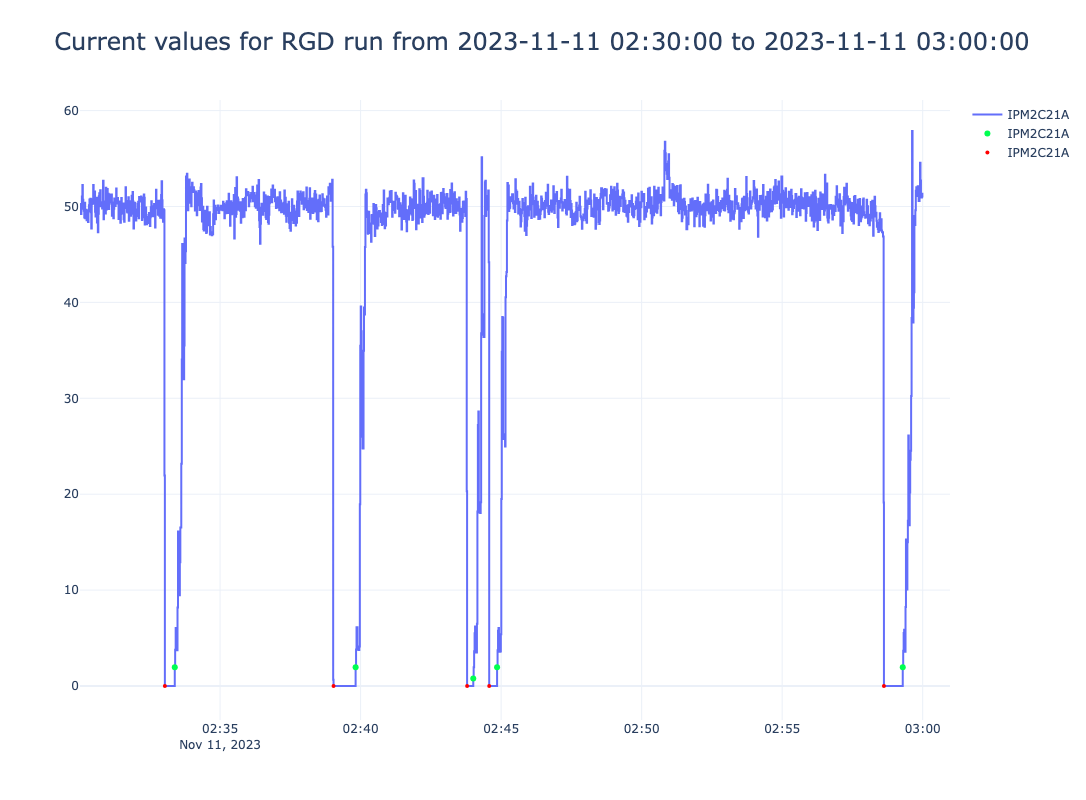

In [6]:
fig = make_subplots()  # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1000, height=800,
                  title=go.layout.Title(text=f"Current values for RGD run from {plot_start} to {plot_end}", xanchor="left"),
                  titlefont=dict(size=24),)
print(f"Plotting zeros index start: {current.loc[select_zero_start].index.min()} number of data points: {current.loc[select_zero_start].time.count()}")
print(f"Plotting zeros index end:   {current.loc[select_zero_end].index.min()} number of data points: {current.loc[select_zero_end].time.count()}")
fig.add_trace(go.Scatter(x=current.loc[select].time, y=current.loc[select].value,  name=name, line=dict(color="light blue", shape="hv")))
fig.add_trace(go.Scatter(x=current.loc[select_zero_end].time, y=current.loc[select_zero_end]["value"],  name=name, mode="markers", marker=dict(color="#00FF50",size=6)))
fig.add_trace(go.Scatter(x=current.loc[select_zero_start].time, y=current.loc[select_zero_start]["value"],  name=name, mode="markers", marker=dict(color="red",size=4)))

#fig.update_yaxes(range=[0, 35])
fig.show()

In [7]:
# I do not think this can be done without looping through the start points where the current drops to zero.
offset_data = []
for i in range(len(current.loc[select_zero_start].index)):
     idx = current.loc[select_zero_start].index[i]
     data_range = current_scalerS2b.loc[(current_scalerS2b.ms>current.loc[idx].ms)&(current_scalerS2b.ms<(current.loc[idx+1].ms-2500))]
     offset_data.append({"index":idx,"time":data_range.iloc[0].time, "ms":data_range.iloc[0].ms,"dt":(data_range.iloc[-1].ms-data_range.iloc[0].ms), "mean":data_range.value.mean(), "std":data_range.value.std(), "count":data_range.value.count(), "min":data_range.value.min(), "max":data_range.value.max()})
offset_df_all = pd.DataFrame(offset_data)
offset_df=offset_df_all.loc[offset_df_all["count"]>10]

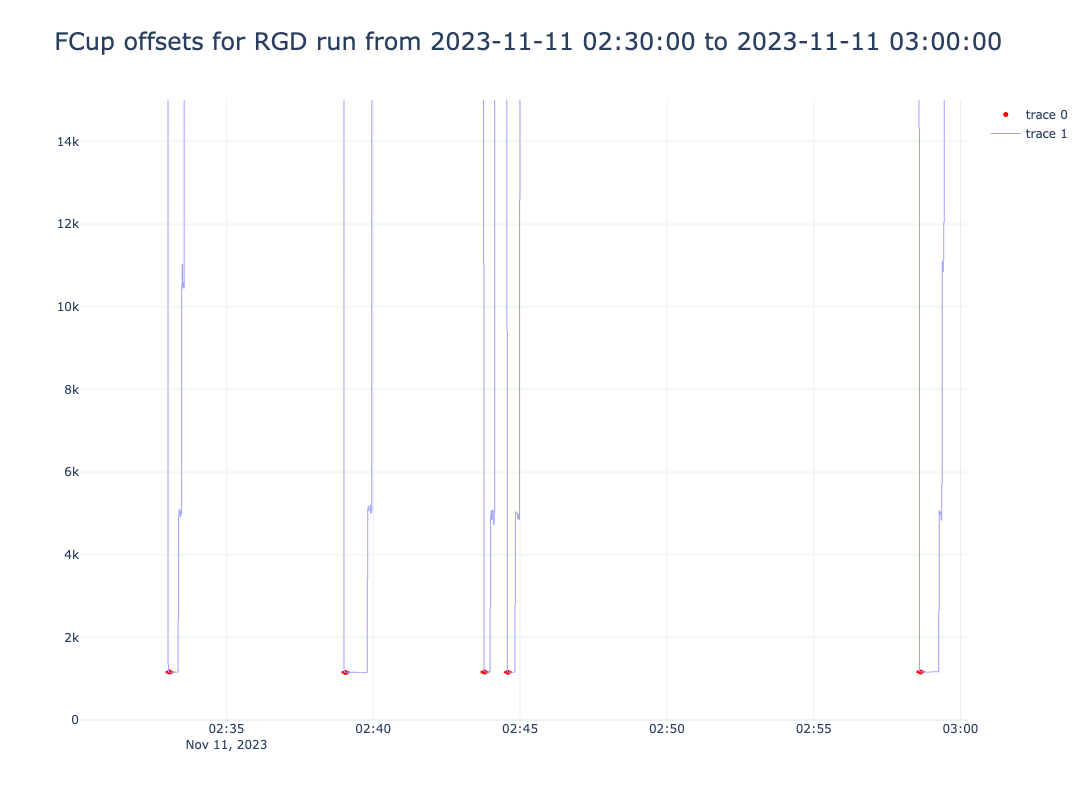

In [8]:
select_scalerS2b = (current_scalerS2b.time>plot_start)&(current_scalerS2b.time<plot_end)
fig = make_subplots()  # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1000, height=800,
                  title=go.layout.Title(text=f"FCup offsets for RGD run from {plot_start} to {plot_end}", xanchor="left"),
                  titlefont=dict(size=24),)
fig.add_trace(trace=go.Scatter(x=offset_df.time, y=offset_df["mean"], error_y=dict(type="data",array=offset_df["std"]),mode="markers", marker=dict(color="#FF0000",size=5)))
fig.add_trace(trace=go.Scatter(x=current_scalerS2b.loc[select_scalerS2b].time, y=current_scalerS2b.loc[select_scalerS2b].value, line=dict(color="#A0A0FF", shape="hv", width=1)))

fig.update_yaxes(range=[0, 15000])
fig.show()

In [9]:
current_scalerS2b.loc[select_scalerS2b]

,ms,value,time,run_number
2976978,1699669800730,31570.0,2023-11-11 02:30:00.730,1
2976979,1699669801764,31083.0,2023-11-11 02:30:01.764,1
2976980,1699669802797,31039.0,2023-11-11 02:30:02.797,1
2976981,1699669803830,31530.0,2023-11-11 02:30:03.830,1
2976982,1699669804864,31738.0,2023-11-11 02:30:04.864,1
...,...,...,...,...
2978697,1699671595742,31745.0,2023-11-11 02:59:55.742,1
2978698,1699671596775,31343.0,2023-11-11 02:59:56.775,1
2978699,1699671597808,31617.0,2023-11-11 02:59:57.808,1
2978700,1699671598842,31559.0,2023-11-11 02:59:58.842,1


# All Data
Now compute the offset for all the data.

We make a cut for beam drops there were too short to have fewer than 30 FCup readouts. It would be possible to combine such data with the next beam drop, but the extra code does not seem warranted at this time.

In [3]:
current, name, color = (current_IPM2C21A,"IPM2C21A","red")
select_zero_start = (np.diff(current.value,prepend=0)<-0.2)& (current.value<.01)
# I do not think this can be done without looping through the start points where the current drops to zero.
offset_data = []
for i in range(len(current.loc[select_zero_start].index)):
    idx = current.loc[select_zero_start].index[i]
    if idx>len(current)-2:
        break
    data_range = current_scalerS2b.loc[(current_scalerS2b.ms>current.loc[idx].ms)&(current_scalerS2b.ms<(current.loc[idx+1].ms-2500))]
    if data_range.value.count()>30 and data_range.value.std()<20:
        offset_data.append({"index":idx,"time":data_range.iloc[0].time, "ms":data_range.iloc[0].ms,"dt":(data_range.iloc[-1].ms-data_range.iloc[0].ms), "mean":data_range.value.mean(), "std":data_range.value.std(), "count":data_range.value.count(), "min":data_range.value.min(), "max":data_range.value.max()})
offset_df= pd.DataFrame(offset_data)
offset_df = offset_df.loc[offset_df["std"]<30]
# offset_df=offset_df.loc[offset_df_all["count"]>30]

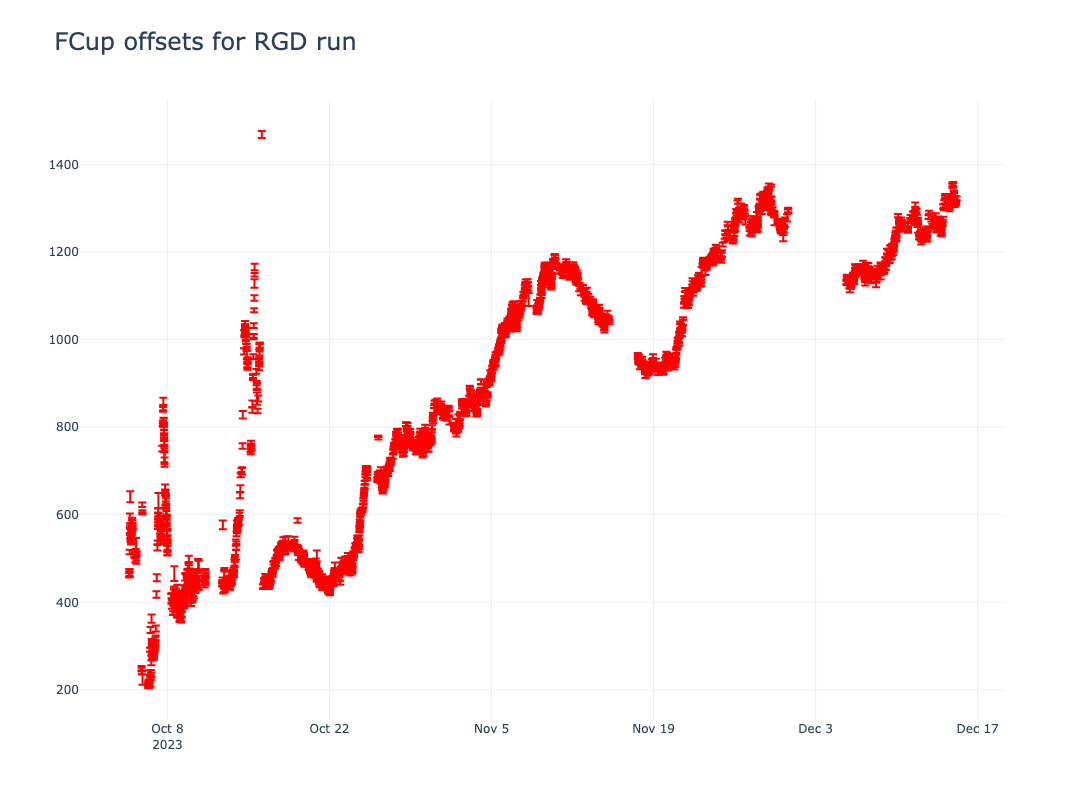

In [4]:
#offset_df= pd.DataFrame(offset_data)
offset_df = offset_df.loc[offset_df["std"]<30]
fig = make_subplots()  # (specs=[[{"secondary_y": True}]])
fig.update_layout(width=1000, height=800,
                  title=go.layout.Title(text=f"FCup offsets for RGD run", xanchor="left"),
                  titlefont=dict(size=24),)
fig.add_trace(trace=go.Scatter(x=offset_df.time, y=offset_df["mean"], error_y=dict(type="data",array=offset_df["std"]),mode="markers", marker=dict(color="#FF0000",size=1),line=dict(color="#A0A0FF", shape="hv", width=1)))
fig.show()

In [5]:
offset_df.set_index(['time'], inplace=True)  # Make the time column the index for the offset_f
offset_df_indexes = offset_df.index.get_indexer(current_scalerS2b.time, method="ffill")
offset_df_indexes[offset_df_indexes==-1] = 0
current_scalerS2b["offset"] = offset_df.iloc[offset_df_indexes,3].to_list()
current_scalerS2b["offset_std"] = offset_df.iloc[offset_df_indexes,4].to_list()

In [6]:
offset_df   

,index,ms,dt,mean,std,count,min,max
time,,,,,,,,
2023-10-04 16:54:02.422,2108,1696438442422,54771,462.260000,4.976721,50,451.0,471.0
2023-10-04 16:59:31.034,2363,1696438771034,100235,472.255556,4.084944,90,462.0,480.0
2023-10-04 17:11:44.715,2939,1696439504715,249041,464.727679,5.543302,224,451.0,482.0
2023-10-04 17:17:35.023,3032,1696439855023,180829,465.975000,5.144393,160,454.0,480.0
2023-10-04 17:23:04.665,3169,1696440184665,109528,466.495146,9.399493,103,430.0,494.0
...,...,...,...,...,...,...,...,...
2023-12-15 00:36:51.058,3617038,1702600611058,1974911,1310.243292,7.770912,1677,1291.0,1401.0
2023-12-15 01:55:10.211,3619654,1702605310211,55834,1322.520000,4.990767,50,1311.0,1330.0
2023-12-15 03:06:20.388,3623663,1702609580388,102301,1310.433333,3.762769,90,1303.0,1321.0


In [10]:
current_scalerS2b

,ms,value,time,run_number,offset,offset_std
0,1696435200738,478.0,2023-10-04 16:00:00.738,1,462.260000,4.976721
1,1696435201769,487.0,2023-10-04 16:00:01.769,1,462.260000,4.976721
2,1696435202797,477.0,2023-10-04 16:00:02.797,1,462.260000,4.976721
3,1696435203829,480.0,2023-10-04 16:00:03.829,1,462.260000,4.976721
4,1696435204869,475.0,2023-10-04 16:00:04.869,1,462.260000,4.976721
...,...,...,...,...,...,...
5670013,1702616394819,1321.0,2023-12-15 04:59:54.819,1,1322.272727,4.331002
5670014,1702616396886,1322.0,2023-12-15 04:59:56.886,1,1322.272727,4.331002
5670015,1702616397919,1321.0,2023-12-15 04:59:57.919,1,1322.272727,4.331002
5670016,1702616398952,1314.0,2023-12-15 04:59:58.952,1,1322.272727,4.331002


In [7]:
store = HDFStore("RGD_mya_data_offset.h5")
store.put('computed_fcup_offset',offset_df)
store.put('scalerS2b',current_scalerS2b)
store.close()

In [10]:
store = HDFStore("RGD_mya_data.h5")
store.put('computed_fcup_offset',offset_df)
store.put('scalerS2b',current_scalerS2b)
store.put("IPM2C21A", current_IPM2C21A)
store.put("IPM2C24A", current_IPM2C24A)
store.put("IPM2H01", current_IPM2H01)
store.put("scalerS2b", current_scalerS2b)
store.put("scaler_calc1b", current_FCup)
store.put("fcup_offset", FCup_offset)
store.put("fcup_slope", FCup_slope)
store.put("beam_stop", FCup_beam_stop)
store.put("beam_stop_atten", FCup_beam_atten)
store.put("DAQ_livetime", LT_DAQ)
store.put("Trigger_livetime", LT_Trigger)
store.put("Pulser_livetime", LT_clock)
store.close()